# Fitting a FLMP
In this notebook, we will fit a Fuzzy Logical Model of Perception (FLMP) to audiovisual speech perception data.

In [1]:
import numpy as np
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt

from libfunc import to_table_body
import flmp

## Prepare Data
The data consists of five text files, each containing seven rows and five columns, where:
- Row 1: Audiotorial data
- Row 2: Visual data
- Rows 3-7: Audiovisual data
    - a combination of rows 1 and 2
    - visual goes from 'b' (row 3) to 'd' (row 7) 
    - audio goes from 'b' (col 1) to 'd' (col 5)

In [2]:
# get paths to data files
file_paths = glob("./data/*.txt")

# load all data into a single array
data = np.array([np.loadtxt(fname) for fname in file_paths])
N, M, K = data.shape

# define number of samples for each subject
n_samples = 24 

## Fit FLMP

In [3]:
# perform FLMP fit for each subject
p_set = []
params = []
objective = []
for i in range(K):
    # Initialize parameters
    theta = np.zeros(K*2)

    # fit params for a single subject
    obj, tA, tV = flmp.fit(theta, data[i], n_samples, K)

    # compute probabilities
    p_A, p_V, p_AV = flmp.compute_probs(tA, tV)

    # store results
    p_set.append(np.vstack([p_A.T, p_V.T, p_AV]))
    objective.append(obj)
    params.append(np.concatenate([tA, tV]))

# print results
print(f'Negative log-likelihoods:\n{to_table_body(np.array([objective]).T)}')
print('\nParams')
print(to_table_body(params))

Negative log-likelihoods:
Subject 1 & 47.34\\
Subject 2 & 32.99\\
Subject 3 & 53.38\\
Subject 4 & 46.91\\
Subject 5 & 42.81

Params
Subject 1 & -3.31 & -2.29 & -1.52 & 2.46 & 3.21 & -2.97 & 0.84 & 2.91 & 3.58 & 3.83\\
Subject 2 & -3.68 & -1.83 & -0.32 & 2.58 & 4.83 & -5.29 & 0.91 & 3.20 & 5.09 & 5.87\\
Subject 3 & -2.65 & -1.74 & -0.69 & 2.62 & 5.41 & -2.00 & 0.25 & 1.54 & 2.37 & 2.62\\
Subject 4 & -4.12 & -3.11 & -2.04 & 2.25 & 4.62 & -2.52 & -1.19 & -0.31 & 1.26 & 2.12\\
Subject 5 & -5.43 & -3.93 & -1.42 & 2.92 & 6.24 & -3.01 & 0.42 & 1.73 & 2.42 & 3.05


# Visualize Results

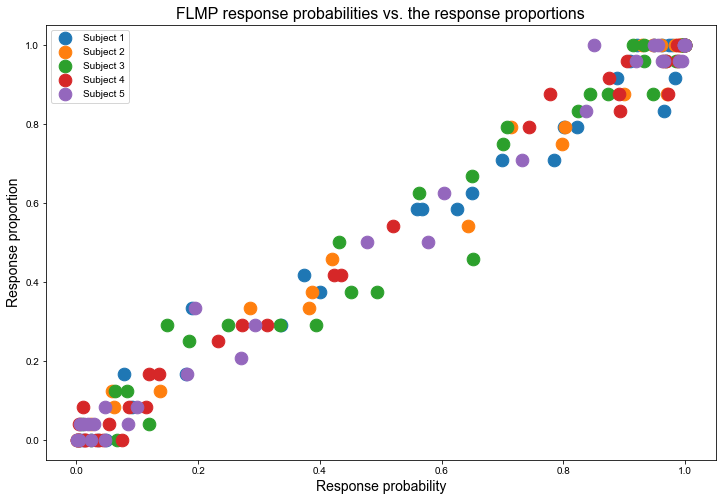

In [4]:
# define stuff to plot
x = p_set
y = list(data/24)

# plot FLMP response probabilities vs. response proportions
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
for idx in range(len(x)):
    ax1.scatter(x[idx], y[idx], s=160, label=f'Subject {idx+1}')
plt.legend(loc='upper left')
plt.title("FLMP response probabilities vs. the response proportions", fontsize=16)
plt.xlabel('Response probability', fontsize=14)
plt.ylabel('Response proportion', fontsize=14)
sns.set_style("whitegrid")
plt.savefig('./visualizations/flmp_scatter.png', transparent=True)
plt.show()